In [341]:
import pandas as pd
import requests
import yfinance as yf
import investpy
from bs4 import BeautifulSoup
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [342]:
class Accion:
    def __init__(self, mercado, datosAccion):
        self.symbol = datosAccion[mercado.campo_nombre]
        self.max = datosAccion[mercado.campo_valorMaximo]
        self.min = datosAccion[mercado.campo_valorMinimo]
        self.ult = datosAccion[mercado.campo_UltimoPrecio]
        self.mov = datosAccion[mercado.campo_cambio]
        self.origen = mercado.__class__.__name__

    def keys(self):
        return ('symbol', 'max', 'min', 'ult', 'mov', 'origen')

    def __getitem__(self, item):
        return getattr(self, item)


In [343]:

class Coleccion:
    def __init__(self, nombreBD, nombreColeccion):
        self.__abrirColeccion(nombreBD, nombreColeccion)

    def __abrirColeccion(self, nombreBD, nombreColeccion):
        client = MongoClient('localhost')
        bd = client[nombreBD]
        self.datos = bd[nombreColeccion]

    def borrarColeccion(self):
        self.datos.drop()


In [344]:

class Origen:
    def __init__(self):
        self.bd = Coleccion('Mercados', self.__class__.__name__)
        self.coleccion = self.bd.datos
        self.bd.borrarColeccion()
        
    def _guardarEnBD(self, dataFrame):
        array_objetos = []
        dataFrame = dataFrame.to_dict('records')
        for fila in dataFrame:
            fila_accion = dict(Accion(self, fila))
            array_objetos.append(fila_accion)
        self.coleccion.insert_many(array_objetos)
        
    def visualizarBD(self):
        for documento in self.coleccion.find({}):
            print(documento)
            
    def visualizarDF(self):
        df = self.__documentADF(self.coleccion.find({}))
        print (df)
        return df

    def __documentADF(self, listColeccion):
        df = pd.DataFrame(list(listColeccion))
        return df.drop(['_id'], axis=1)
        
    def gananciaPerdidaAcciones(self,cantidad):
        df = self.visualizarDF()
        df = df.sort_values(by='mov', ascending = False)
        print()
        print("Acciones de mayor ganancia\n",df.head(cantidad))
        print()
        print("Acciones de mayor pérdida\n",df.tail(cantidad))
    
    #vamos a graficar los valores positivos de un color y los negativos de otro color
    def graficarGananciaPerdida(self,titulo,nombre):
        df = self.visualizarDF()
        dfPositivos = df[df['mov'] >= 0]
        dfPositivos = dfPositivos.rename({'mov': 'Ganancia'}, axis=1)  #renombramos la columna como Ganancia
        #seleccionamos los valores negativos
        dfNegativos = df[df['mov'] < 0]
        dfNegativos = dfNegativos.rename({'mov': 'Pérdida'}, axis=1) #renombramos la columna como Pérdida
        df = pd.concat([dfPositivos,dfNegativos]).sort_values(by='symbol')   #unimos las tablas ordenadas por el nombre
        #armamos el gráfico 
        #parámetros: columnas, tipo de gráfico, ancho de las barras, colores de las barras
        plt.style.use('seaborn') #estilo grafico
        df[['symbol', 'Ganancia', 'Pérdida']].plot('symbol', kind="bar", width=1, color=["#04D8B2","#EF4026"], figsize=(12,12))
        plt.title(titulo) #título del grafico
        plt.xlabel('Acciones') #título del eje de las x
        #guardamos el gráfico, 'tight' s para que se guarde el gráfico de manera completa
        #parámetro: nombre
        plt.savefig(nombre, bbox_inches='tight')
        plt.tight_layout();plt.show() #mostramos el gráfico de manera completa

    def filtrarAcciones(self, nombreAccion):
        accion = self.coleccion.find({'symbol': {"$in": nombreAccion}})
        df = self.__documentADF(accion)
        return df

    def accion(self, symbol):
        return Accion(self, self.coleccion.find_one({self.campo_nombre: symbol}))

In [345]:
       
class bolsaMadrid(Origen):
    campo_nombre = 'Nombre'
    campo_valorMaximo = 'Máx'
    campo_valorMinimo = 'Mín'
    campo_UltimoPrecio = 'Últ'
    campo_cambio = '% Dif'
    
    def __init__(self):
        super().__init__()

    def actualizarBD(self):
        #Hacemos la consulta a la pagina y guardamos el contenido en una variable soup
        url_page = 'https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000'
        page = requests.get(url_page).text 
        soup = BeautifulSoup(page, "lxml")

        #Buscamos la tabla de donde obtener los datos
        tabla = soup.find('table', attrs={'id': 'ctl00_Contenido_tblAcciones'})

        #creamos una lista vacia que llenaremos con los datos de las tablas
        columnas = []

        #buscamos los encabezados de la tabla y los agregamos a la lista columnos (deberia ubicarse en la posicion 0)
        headers = []
        for th in tabla.find_all('th'):
            headers.append(th.text.replace('.',''))
        columnas.append(headers)

        for tr in tabla.find_all('tr'):
            fila = []
            for td in tr.find_all('td'):
                fila.append(td.text)
            if len(fila) > 0:
                columnas.append(fila)
                
        #creamos el dataframe usando la lista columnas,pasamos el contenido (de la posicion 1 en adelante), y lo encabezados en (posicion 0)
        df = pd.DataFrame(columnas[1:], columns=columnas[0])

        #Convertirmos a float
        df = self.__convertirAFloat(df)

        #Guardamos los datos en la base de datos
        self._guardarEnBD(df)
        
    def __convertirAFloat(self, df):
        df["% Dif"] = df["% Dif"].str.replace(",", ".").astype(float)
        df["Máx"] = df["Máx"].str.replace(",", ".").astype(float)
        df["Mín"] = df["Mín"].str.replace(",", ".").astype(float)
        df["Últ"] = df["Últ"].str.replace(",", ".").astype(float)
        return df

nombreDeAcciones =[
    'BBVA', "BBVA.MC",
    'ELE', "ELE.MC", 'ENDESA',
    'GRLS', "GRF.MC", 'GRIFOLS CL.A',
    'INDRA A', 'IDR',"IDR.MC",
    "REP.MC", 'REP','REPSOL'
    ]

bolsamadrid = bolsaMadrid()
bolsamadrid.actualizarBD()
print(bolsamadrid.filtrarAcciones(nombreDeAcciones))

#bolsamadrid.visualizarDF()
""" bolsamadrid.gananciaPerdidaAcciones(df_BM,'% Dif',2)
bolsamadrid.graficarGananciaPerdida(df_BM, x='Nombre', y='% Dif', titulo='Bolsa de Madrid. Ganancia o pérdida de las acciones', nombre='Ganan_perd_BolsaMadrid.png')
accion = bolsamadrid.accion('BBVA')
print(accion.mov) """

         symbol     max     min     ult   mov       origen
0          BBVA   6.107   5.997   6.026 -0.23  bolsaMadrid
1        ENDESA  20.200  19.885  20.000  1.19  bolsaMadrid
2  GRIFOLS CL.A  18.850  18.160  18.500 -1.86  bolsaMadrid
3       INDRA A  10.900  10.640  10.780  0.84  bolsaMadrid
4        REPSOL  10.878  10.584  10.812  0.86  bolsaMadrid


" bolsamadrid.gananciaPerdidaAcciones(df_BM,'% Dif',2)\nbolsamadrid.graficarGananciaPerdida(df_BM, x='Nombre', y='% Dif', titulo='Bolsa de Madrid. Ganancia o pérdida de las acciones', nombre='Ganan_perd_BolsaMadrid.png')\naccion = bolsamadrid.accion('BBVA')\nprint(accion.mov) "

In [346]:
class yfinance(Origen):
    campo_nombre = 'Ticker'
    campo_valorMaximo = 'High'
    campo_valorMinimo = 'Low'
    campo_UltimoPrecio = 'Close'
    campo_cambio = 'Dif'
    
    def __init__(self):
        super().__init__()

    def actualizarBD(self, acciones):
        df_list = list()
        for accion in acciones:
            if not " " in accion and ".MC" in accion:
                data = yf.download(accion, group_by='ticker', period='1d')
                if not data.empty:
                    data['Ticker'] = accion
                    data['Dif'] = self.__calcularDiferencia(data['Open'], data['Close'])
                    df_list.append(data)

        if len(df_list) > 0:
            df = pd.concat(df_list)
            self._guardarEnBD(df)
    
    def __calcularDiferencia(self, A, B):
        return (B*100)/A-100

yahooFinance = yfinance()
yahooFinance.actualizarBD(nombreDeAcciones)
#yahooFinance.visualizarBD()
#yahooFinance.visualizarDF()
yahooFinance.filtrarAcciones(nombreDeAcciones)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,symbol,max,min,ult,mov,origen
0,BBVA.MC,6.107000,5.997,6.026,-0.033176,yfinance
1,ELE.MC,20.200001,19.885,20.000,0.000000,yfinance
2,GRF.MC,18.850000,18.160,18.500,-1.069523,yfinance
3,IDR.MC,10.900000,10.640,10.780,1.030925,yfinance
4,REP.MC,10.878000,10.584,10.812,0.952383,yfinance


   symbol       max       min       ult   mov    origen
0     ACS   23.3550   22.4550   23.3100  3.92  investPy
1     A3M    3.6060    3.5200    3.5800  1.70  investPy
2     ACX   11.4220   11.2140   11.2300 -0.80  investPy
3    BBVA    6.1070    5.9970    6.0260 -0.23  investPy
4     BKT    5.0040    4.8760    4.9670  1.82  investPy
5     ANA  160.0000  155.4000  156.6000 -1.39  investPy
6    CABK    2.5270    2.4600    2.5100  1.58  investPy
7    ENAG   20.1850   19.8980   20.0900  0.80  investPy
8     FCC   11.1200   10.9500   11.1000  0.73  investPy
9    NTGY   23.5600   23.2750   23.4300  0.04  investPy
10  SGREN   19.3430   18.3370   18.8000 -3.14  investPy
11   GRLS   18.8050   18.1850   18.4800 -2.07  investPy
12    FER   27.5800   26.8850   27.5400  2.04  investPy
13    REE   18.2650   18.1050   18.1100 -0.67  investPy
14    ITX   32.3450   31.7500   32.1850  0.48  investPy
15    REP   10.8810   10.5850   10.8300  1.36  investPy
16    IBE   10.3320   10.1620   10.2830  1.06  i

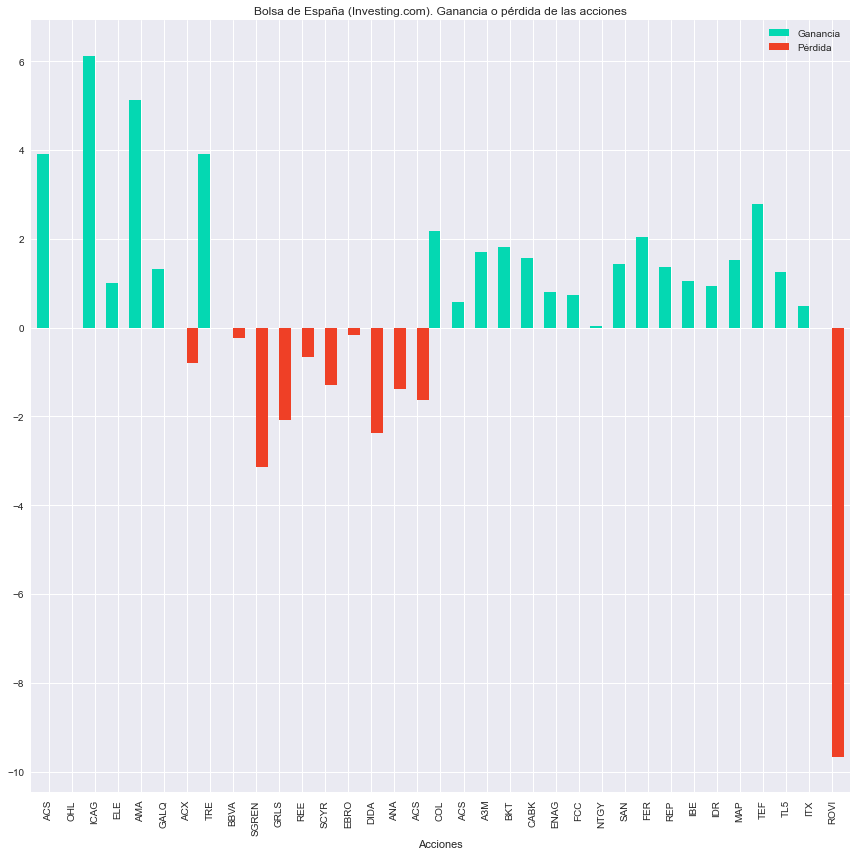

' invest.visualizarBD()\ninvest.visualizarDF()\n'

In [347]:
class investPy(Origen):
    
    campo_nombre = 'symbol'
    campo_valorMaximo = 'high'
    campo_valorMinimo = 'low'
    campo_UltimoPrecio = 'last'
    campo_cambio = 'GP'
    
    def __init__(self):
        super().__init__()


    def actualizarBD(self):
        df = investpy.stocks.get_stocks_overview(country='spain', as_json = False , n_results = 35)  
        df = self.__porcentajeCambio(df)
        #cambiar la columna a numérica
        df['GP'] = df['GP'].apply(pd.to_numeric)
        self._guardarEnBD(df)
    
    def __porcentajeCambio(self, df):
        return df.join(df['change_percentage'].str.partition('%')[[0, 1]]).rename({0: 'GP', 1: '%'}, axis=1)

invest = investPy()
invest.actualizarBD()
#invest.gananciaPerdidaAcciones(2)
invest.graficarGananciaPerdida(titulo='Bolsa de España (Investing.com). Ganancia o pérdida de las acciones', nombre='Ganan_perd_Investpy.png')
""" invest.visualizarBD()
invest.visualizarDF()
""" 



In [350]:
class Cotizaciones():

    def __init__(self, acciones, mercados):
        self.acciones = acciones
        self.mercados = mercados
       
    def juntarDBS(self):
        df = pd.DataFrame()
        for mercado in self.mercados:
            df = pd.concat([df, mercado.filtrarAcciones(self.acciones)], axis=0)
        return df


In [352]:

cotizaciones = Cotizaciones(nombreDeAcciones, [bolsamadrid, yahooFinance, invest])
print(cotizaciones.juntarDBS())



         symbol        max     min     ult       mov       origen
0          BBVA   6.107000   5.997   6.026 -0.230000  bolsaMadrid
1        ENDESA  20.200000  19.885  20.000  1.190000  bolsaMadrid
2  GRIFOLS CL.A  18.850000  18.160  18.500 -1.860000  bolsaMadrid
3       INDRA A  10.900000  10.640  10.780  0.840000  bolsaMadrid
4        REPSOL  10.878000  10.584  10.812  0.860000  bolsaMadrid
0       BBVA.MC   6.107000   5.997   6.026 -0.033176     yfinance
1        ELE.MC  20.200001  19.885  20.000  0.000000     yfinance
2        GRF.MC  18.850000  18.160  18.500 -1.069523     yfinance
3        IDR.MC  10.900000  10.640  10.780  1.030925     yfinance
4        REP.MC  10.878000  10.584  10.812  0.952383     yfinance
0          BBVA   6.107000   5.997   6.026 -0.230000     investPy
1          GRLS  18.805000  18.185  18.480 -2.070000     investPy
2           REP  10.881000  10.585  10.830  1.360000     investPy
3           IDR  10.900000  10.640  10.760  0.940000     investPy
4         